In [531]:
import numpy as np
import pandas as pd
import string

import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='white', palette='deep', font_scale=1.5, color_codes=True)

### Lemmatize

In [62]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andrewblaikie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewblaikie/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [38]:
lemma = WordNetLemmatizer()
print(lemmatizer.lemmatize('snakes'))

snake


### Stemmer

In [29]:
stemmer = SnowballStemmer('english')
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing']
singles = [stemmer.stem(plural) for plural in original_words]
pd.DataFrame(data = {'original word': original_words, 'stemmed': singles})

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


### Tokenizer and Preprocessor

In [297]:
stop_words = stopwords.words('english')
stop_words.extend(['would'])
punctuation = string.punctuation

In [309]:
def preprocessor(text):
    stopwordremoval = " ".join([i for i in text.lower().split() if i not in stop_words])
    punctuationremoval = ''.join(ch for ch in stopwordremoval if ch not in punctuation)
    normalized = " ".join(lemmatizer.lemmatize(word) for word in punctuationremoval.split())
    return normalized.split()

### Data

In [288]:
happy_reviews = pd.read_csv('data/hotel_happy_reviews.csv')
unhappy_reviews = pd.read_csv('data/hotel_not_happy_reviews.csv')

In [289]:
happy_reviews.head()

,User_ID,Description,Is_Response,hotel_ID
0,id10329,Stayed here with husband and sons on the way t...,happy,8
1,id10331,We had - rooms. One was very nice and clearly ...,happy,3
2,id10333,My wife & I stayed in this glorious city a whi...,happy,3
3,id10334,My boyfriend and I stayed at the Fairmont on a...,happy,7
4,id10336,"Steps off Times Square, nice rooms, stayed - n...",happy,3


In [290]:
unhappy_reviews.head()

,User_ID,Description,Is_Response,hotel_ID
0,id10326,The room was kind of clean but had a VERY stro...,not happy,3
1,id10327,I stayed at the Crown Plaza April -- - April -...,not happy,9
2,id10328,I booked this hotel through Hotwire at the low...,not happy,3
3,id10330,My girlfriends and I stayed here to celebrate ...,not happy,3
4,id10332,My husband and I have stayed in this hotel a f...,not happy,7


In [310]:
preprocessor(unhappy_reviews['Description'][0])

['room',
 'kind',
 'clean',
 'strong',
 'smell',
 'dog',
 'generally',
 'average',
 'ok',
 'overnight',
 'stay',
 'fussy',
 'consider',
 'staying',
 'price',
 'right',
 'breakfast',
 'free',
 'better',
 'nothing']

In [293]:
happy_reviews = happy_reviews.assign(happy=1)
unhappy_reviews = unhappy_reviews.assign(happy=0)

In [506]:
reviews = pd.concat([happy_reviews, unhappy_reviews], ignore_index = True)

In [342]:
cleaned_reviews=reviews['Description'].apply(preprocessor)

In [507]:
reviews.insert(loc=2, column='tokens', value=cleaned_reviews)

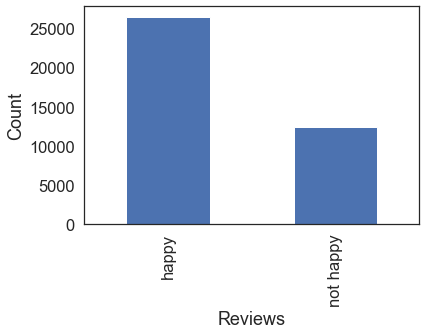

In [405]:
reviews['Is_Response'].value_counts().sort_index().plot(kind='bar');
plt.ylabel("Count");
plt.xlabel("Reviews");

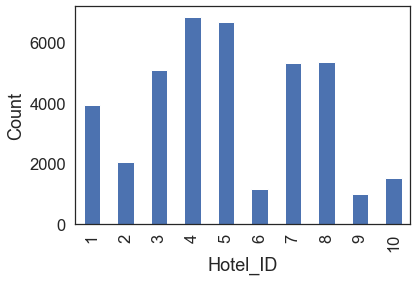

In [409]:
reviews['hotel_ID'].value_counts().sort_index().plot(kind='bar');
plt.ylabel("Count");
plt.xlabel("Hotel_ID");

In [411]:
review_lengths = reviews['tokens'].apply(len)

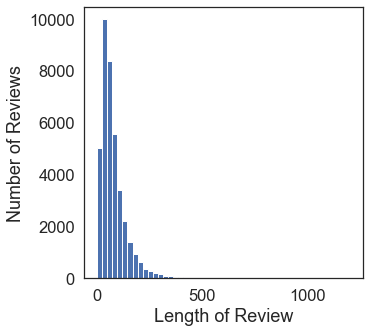

In [415]:
fig = plt.figure(figsize=(5,5))
plt.hist(review_lengths, bins=50)
plt.xlabel('Length of Review')
plt.ylabel('Number of Reviews')
plt.show()

### Now find the cateogories

In [425]:
dictionary = gensim.corpora.Dictionary(reviews['tokens'])

In [426]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [365]:
bow_corpus = [dictionary.doc2bow(doc) for doc in reviews['tokens']]

In [366]:
tfidf = models.TfidfModel(bow_corpus)

In [367]:
corpus_tfidf = tfidf[bow_corpus]

In [522]:
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=15, id2word=dictionary, passes=2, workers=2)

In [529]:
lda_model.print_topics()

[(0,
  '0.004*"square" + 0.004*"location" + 0.004*"union" + 0.004*"great" + 0.004*"wharf" + 0.004*"good" + 0.004*"san" + 0.003*"walk" + 0.003*"fisherman" + 0.003*"francisco"'),
 (1,
  '0.004*"good" + 0.004*"great" + 0.004*"location" + 0.003*"walk" + 0.003*"breakfast" + 0.003*"clean" + 0.003*"restaurant" + 0.003*"nice" + 0.003*"free" + 0.003*"close"'),
 (2,
  '0.003*"bathroom" + 0.003*"small" + 0.003*"bed" + 0.003*"good" + 0.003*"filthy" + 0.003*"broken" + 0.003*"floor" + 0.003*"night" + 0.002*"breakfast" + 0.002*"old"'),
 (3,
  '0.004*"nasty" + 0.003*"good" + 0.003*"service" + 0.003*"nice" + 0.003*"great" + 0.003*"location" + 0.002*"restaurant" + 0.002*"area" + 0.002*"stay" + 0.002*"stayed"'),
 (4,
  '0.003*"u" + 0.003*"time" + 0.002*"night" + 0.002*"one" + 0.002*"service" + 0.002*"desk" + 0.002*"day" + 0.002*"new" + 0.002*"stay" + 0.002*"like"'),
 (5,
  '0.005*"great" + 0.004*"staff" + 0.004*"torn" + 0.004*"overbooked" + 0.004*"service" + 0.004*"wonderful" + 0.004*"friendly" + 0.004*"

In [504]:
lda_model[corpus_tfidf[3]]

[(0, 0.071632616), (6, 0.041969255), (14, 0.77521986)]

In [524]:
topics =[]
topic_scores = []
for i in range(len(reviews['tokens'])):
    topics = {}
    for index, score in lda_model[corpus_tfidf[i]]:
        topics[index]=score 
    topic_scores.append(topics)

In [525]:
topics = pd.DataFrame(topic_scores)

In [526]:
reviews_ = pd.concat([reviews, topics.fillna(0)], axis = 1)

In [530]:
reviews_[reviews_[9]>0.3]

,User_ID,Description,tokens,Is_Response,hotel_ID,happy,0,1,2,3,...,5,6,7,8,9,10,11,12,13,14
7,id10340,I found the hotel clean and nicely located. Go...,"[found, hotel, clean, nicely, located, good, f...",happy,3,1,0.012716,0.012716,0.012716,0.012716,...,0.012716,0.012716,0.012716,0.012716,0.821975,0.012716,0.012716,0.012716,0.012716,0.012716
159,id10573,The hotel was definitely the best place I have...,"[hotel, definitely, best, place, stayed, nyc, ...",happy,8,1,0.016156,0.016156,0.016156,0.016156,...,0.016157,0.016156,0.016156,0.016156,0.773809,0.016156,0.016156,0.016156,0.016156,0.016157
282,id10753,Our family of four stayed - nights at the Carl...,"[family, four, stayed, night, carlyle, suite, ...",happy,4,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.324058,0.000000,0.000000,0.000000,0.556818,0.000000
418,id10950,this was a lovely boutique hotel that was sugg...,"[lovely, boutique, hotel, suggested, u, friend...",happy,5,1,0.309660,0.011220,0.011220,0.011220,...,0.011220,0.011220,0.011220,0.011220,0.544480,0.011220,0.011220,0.011220,0.011220,0.011220
517,id11098,Another awesome visit and stay at Parc --\r\nS...,"[another, awesome, visit, stay, parc, staff, f...",happy,6,1,0.017451,0.017451,0.017451,0.017451,...,0.017451,0.017451,0.017451,0.017451,0.755692,0.017451,0.017451,0.017451,0.017451,0.017451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36168,id40670,We stayed at the Homestead Suites for the Aust...,"[stayed, homestead, suite, austin, city, limit...",not happy,4,0,0.014375,0.014375,0.014375,0.014375,...,0.014375,0.014375,0.014375,0.486897,0.326229,0.014375,0.014375,0.014375,0.014375,0.014375
36301,id41107,Husband and I stayed for a week . Hallways cou...,"[husband, stayed, week, hallway, couldve, bett...",not happy,10,0,0.013919,0.013919,0.013919,0.013919,...,0.013919,0.013919,0.013919,0.013919,0.805130,0.013919,0.013919,0.013919,0.013919,0.013919
36603,id41974,TODOS PENSAMOS QUE UN HOTEL DE LA CATEGORIA DE...,"[todos, pensamos, que, un, hotel, de, la, cate...",not happy,6,0,0.016841,0.016838,0.016838,0.016837,...,0.016837,0.016837,0.016837,0.016838,0.479267,0.227503,0.016837,0.016837,0.091176,0.016837
36926,id43029,"We spent - nights at the Majestic, the hotel i...","[spent, night, majestic, hotel, bit, old, sure...",not happy,5,0,0.000000,0.000000,0.000000,0.380423,...,0.000000,0.000000,0.000000,0.000000,0.496536,0.000000,0.000000,0.000000,0.000000,0.000000


In [528]:
for index, score in sorted(lda_model[corpus_tfidf[3]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.7784066796302795	 
Topic: 0.003*"great" + 0.003*"nice" + 0.003*"good" + 0.003*"clean" + 0.003*"breakfast" + 0.003*"area" + 0.003*"restaurant" + 0.003*"location" + 0.002*"staff" + 0.002*"metro"

Score: 0.10118043422698975	 
Topic: 0.006*"roach" + 0.005*"dog" + 0.005*"crawling" + 0.005*"pet" + 0.004*"stink" + 0.004*"ancient" + 0.003*"mgr" + 0.003*"magnolia" + 0.003*"clean" + 0.003*"great"


In [274]:
unhappy_reviews['Description'][3]

"My girlfriends and I stayed here to celebrate our --th birthdays. We had planned this weekend getaway back in February, so we were all looking forward to it. There was - of us so we rented - ajoining rooms at the rate of $----night-room. We stayed - nights so with taxes and parking charges we spent in total over $----. All of us expected a certain level of service since we were staying at the Ritz, however this hotel certainly didn't meet what we would consider Ritz standards.\r\nThe rooms were fine. They were clean with well appointed bathrooms, but nothing to get excited about. The service however was awful. The first night we were there, I made -- calls to the bell man, before someone in hotel communications picked up the phone. Then on Saturday night before we left for dinner at -:--, we requested to have extra hotels delivered to our room and our trash removed. When we returned at --:--, neither request was fullfilled. I made another call to housekeeping and then finally things w

In [620]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

tf = vectorizer.fit_transform(unhappy_reviews['Description'])

In [628]:
lda = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [629]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [630]:
topic_words = []
feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(lda.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-5 - 1:-1]])
        topic_words.append(message)
set(topic_words)

{'Topic #0: room bathroom bed shower floor',
 'Topic #1: hotel service staff room stay',
 'Topic #2: room hotel told desk said',
 'Topic #3: room night hotel noise floor',
 'Topic #4: hotel san rooms area location',
 'Topic #5: place stay bed dirty sheets',
 'Topic #6: hotel room location rooms good',
 'Topic #7: room breakfast clean hotel air',
 'Topic #8: room door like just don',
 'Topic #9: hotel nice good parking great'}

In [632]:
unhappy_topics = pd.concat([unhappy_reviews, pd.DataFrame(data=lda.transform(tf), columns=topic_words)], axis = 1)

In [634]:
unhappy_topics[unhappy_topics['Topic #5: place stay bed dirty sheets']>0.1]['hotel_ID'].value_counts()

7     260
4     221
3     161
1     157
5     124
2      98
8      78
10     69
9      44
6      35
Name: hotel_ID, dtype: int64